## Naïve Bayes Classifier and Logistic Regression

This notebook implements and experiments on following:
1. Text classicization using Naïve Bayes Classifier
2. Use the classifier to identify the Spam emails.


To test the implementation, we will use the UCI SMS Spam Collection Data Set

In [1]:
# dependencies

import math
import re
import numpy as np
import pandas as pd
import random 
#from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We use text processing library
# Some NLTK dependencies for text preprocessing

import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# This is the metrics function written for previous assignments
# Just importing from a file metrics.py in the current directory

from metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

### Part A: Model Code

#### 1. Multinomial Naive Bayes Classifier

In [7]:
class Multinomial_NB:
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.pi = None
        self.theta = None
        
    # helper function to calculate factorial 
    def factorial(self, n):
        if n == 0 or n == 1:
            return 1
        fact = 1
        for i in range(1, n+1):
            fact *= i
        return fact
        
    # evaluates and updates pi and theta (theta_jc matrix)
    def fit(self, X, y):
        self.X = X; self.y = y
        
        N, d = X.shape
        Nc0 = 0; Nc1 = 0
        for i in y:
            if i == 0: Nc0 += 1
            elif i == 1: Nc1 += 1
            else: raise ValueError('Implementation valid only for binary classification: 0 and 1.')
        # Laplace smoothing
        self.pi = np.array([(Nc0 + self.alpha)/(d*self.alpha + N), (Nc1 + self.alpha)/(d*self.alpha + N)])
        
        # Class separation: Binary class: 0 and 1
        X0 = []; X1 = []
        for x, y in zip(self.X, self.y):
            if y == 0:
                X0.append(x)
            if y == 1:
                X1.append(x)
        X0, X1 = np.array(X0), np.array(X1)
        X0_sum = np.sum(X0, axis=0)
        X1_sum = np.sum(X1, axis=0)
        
        # theta buffer
        theta_jc = np.empty((2, d))
        for j in range(d):
            # storing into 0 or 1 class
            theta_jc[0][j] = (X0_sum[j] + self.alpha) / (d*self.alpha + np.sum(X0_sum))
            theta_jc[1][j] = (X1_sum[j] + self.alpha) / (d*self.alpha + np.sum(X1_sum))
        self.theta = theta_jc
        
    def predict(self, X_test):
        '''
         logP(y=c|x) = logP(c) + logP(x|y=c)
        '''
        # n_samples, n_features
        N, d = X_test.shape
        # log_proba buffer
        log_proba = np.empty((2, N))
        # creating M_i matrix
        M = np.sum(X_test, axis=1)
        for c in [0, 1]:
            for i in range(N):
                log_m_fact = math.log(self.factorial(M[i]))
                log_likelihood = log_m_fact - sum(math.log(self.factorial(X_test[i][j])) -  
                                 X_test[i][j] * math.log( self.theta[c][j]) for j in range(d))
                log_prior = math.log(self.pi[c])
                log_proba[c][i] = log_prior + log_likelihood
                
        # returning the prediction
        y_pred_test = (log_proba[0] < log_proba[1]).astype('int8')
        return y_pred_test
    
    def predict_log_proba(self, X_test):
        '''
         logP(y=c|x) = logP(c) + logP(x|y=c)
        '''
        # n_samples, n_features
        N, d = X_test.shape
        # log_proba buffer
        log_proba = np.empty((2, N))
        # creating M_i matrix
        M = np.sum(X_test, axis=1)
        for c in [0, 1]:
            for i in range(N):
                log_m_fact = math.log(self.factorial(M[i]))
                log_likelihood = log_m_fact - sum(math.log(self.factorial(X_test[i][j])) -  
                                 X_test[i][j] * math.log( self.theta[c][j]) for j in range(d))
                log_prior = math.log(self.pi[c])
                log_proba[c][i] = log_prior + log_likelihood
                
        # returning the prediction log-probability of posterior
        return log_proba

    def predict_proba(self, X_test):
        '''
         logP(y=c|x) = logP(c) + logP(x|y=c)
        '''
        log_proba = self.predict_log_proba(X_test)
                
        # returning the prediction log-probability of posterior
        return np.exp(log_proba)

### Part B: Exploratory Data Aanalysis

In [50]:
2.0
# Getting data ready!

df = pd.read_csv('SMSSpamCollection.csv', header=None)
# renaming columns
df = df.rename({0: 'class', 1: 'email'}, axis='columns')
df.head()

,class,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
# 3.0
df.describe()

,class,email
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
class    5574 non-null object
email    5574 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


In [53]:
# Redo df.describe() after converting strings into numerical values

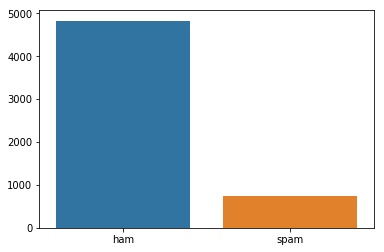

In [54]:
# 4.0
# barplot
sns.barplot(x = df['class'].unique(), y=df['class'].value_counts().values, data=df);

### Part C: Feature Extraction

In [55]:
# 5.0
from nltk import word_tokenize

# function: takes dataframe and returns with normalization
def normalize_text(df, stemming=False, lemmatization=False):
    # stemming
    if stemming is True:
        stemmer = PorterStemmer()
        df['stemmed_email'] = df['email'].apply(lambda email: ' '.join([stemmer.stem(word) for 
                                                                  word in word_tokenize(email)]))
        return df
    # lemmatization
    if lemmatization is True:
        lemmatizer = WordNetLemmatizer()
        # df['lemmatized_email'] = df['email'].apply(lambda email: lemmatizer.lemmatize(email))
        df['lemmatized_email'] = df['email'].apply(lambda email: ' '.join([lemmatizer.lemmatize(word) 
                                                                    for word in word_tokenize(email)]))
        return df

#### 6. Word clouds

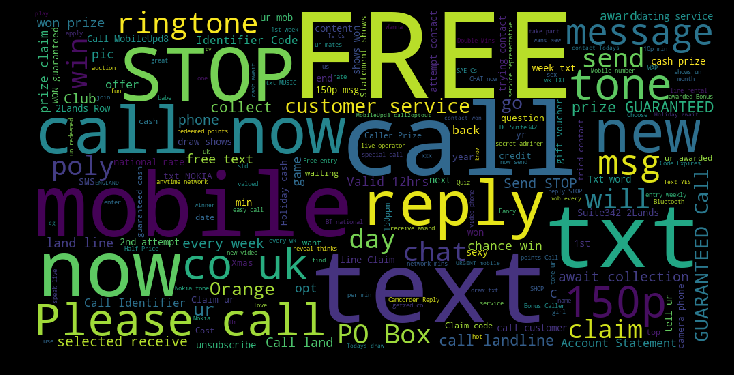

In [56]:
spam_words = ''.join(list(df[df['class']=='spam']['email']))
spam_wordclod = WordCloud(width = 1000,height = 500).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

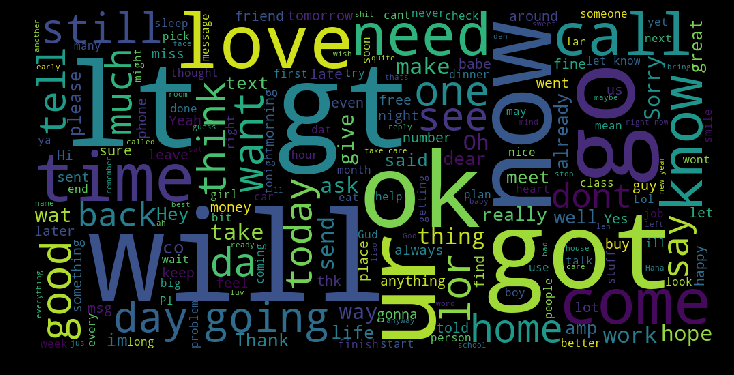

In [57]:
ham_words = ''.join(list(df[df['class']=='ham']['email']))
ham_wordclod = WordCloud(width = 1000,height = 500).generate(ham_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(ham_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

#### 7. Feature Extraction

In [58]:
df['email'] = df['email'].apply(lambda email: email.lower())

#### Some text cleaning....

Let us do some basic text clean up before using them for the classification.

In [59]:
# cleans the words with long numbers
def clean_text(email):
    word_list = word_tokenize(email)
    sentence = []
    for word in word_list:
        if bool(re.search('^[0-9]', word)) and len(word) > 3:
            continue
        # stripping the attached . or , at the end if any
        if bool(re.search('[.|,]$', word)):
            word = word[:-1]
        sentence.append(word)
    return ' '.join([word for word in sentence])

# replacing some very frequent words in the emails

def replace(email, replacements):
    
    email_words = word_tokenize(email)
    keys = list(replacements.keys())
    
    new_email = []
    for word in email_words:
        if word in keys:
            new_email.append(replacements[word])
        else:
            new_email.append(word)
    return ' '.join(new_email)
    
replacements = {"msg": 'message', "ur": 'your', "txt": 'text', "dat": 'that', "im": 'I am', "2nd": "second", "u": 'you',
                "n": 'and', "K": 'ok', "c": 'see', "pls": 'please', "mins": 'minutes', "'ve": 'have', "'re": 'are',
                "'ll": 'will', "dont": 'do not', "n't": 'not', "da": 'the', "cant": 'can not', "luv": 'love'}

In [60]:
# to see the highly repeated words and errors in them
def word_repeats(df):
    emails = df['email'].values
    out_dict = {}
    for email in emails:
        email_words = word_tokenize(email)
        for word in email_words:
            if word in out_dict.keys():
                out_dict[word] += 1
            else:
                out_dict[word] = 1
    return sorted(out_dict.items(), key=itemgetter(1), reverse=True)

In [61]:
# some replacements
df['email'] = df['email'].apply(lambda email: replace(email, replacements))

# removing some other unnecessary or confusing stuffs
df['email'] = df['email'].apply(lambda email: clean_text(email))

# STOP_WORDS
stop_words = stopwords.words('english')

# removing stop_words
df['email'] = df['email'].apply(lambda email: ' '.join([word for word in email.split() if word not in stop_words]))

In [62]:
# lemmatization

df = normalize_text(df, stemming=False, lemmatization=True)

In [63]:
words_counts = word_repeats(df)

In [64]:
# Considering only 500 features/words

count_vector = CountVectorizer(lowercase=True, max_features=500)

In [65]:
#count_vector.get_feature_names()
#count_vector.vocabulary_

#### 8. data preparation

In [66]:
X = count_vector.fit_transform(df['lemmatized_email']).todense()
X = np.array(X)

In [67]:
# class labels
# class ham= 0, and spam = 1

df['label'] = df['class'].apply(lambda label: 0 if label == 'ham' else 1)

In [68]:
df.head()

,class,email,lemmatized_email,label
0,ham,go jurong point crazy. available bugis great w...,go jurong point crazy . available bugis great ...,0
1,ham,ok lar .. joking wif oni ..,ok lar .. joking wif oni ..,0
2,spam,free entry 2 wkly comp win fa cup final tkts m...,free entry 2 wkly comp win fa cup final tkts m...,1
3,ham,dun say early hor .. see already say ..,dun say early hor .. see already say ..,0
4,ham,nah think goes usf lives around though,nah think go usf life around though,0


In [69]:
# label vector
y = df['label'].values

#### 9. shuffling...

In [70]:
# since we have already created X and y 
# the following method will not shuffle X and y rather older df
#df = df.sample(frac=1.0)

In [41]:
# this function shuffles the X, y in place
def shuffle_in_place(X, y):
    assert len(X) == len(y)
    length = len(X)
    for index in range(length):
        swap = random.randrange(length - 1)
        swap += swap >= index
        X[index], X[swap] = X[swap], X[index]
        y[index], y[swap] = y[swap], y[index]

In [42]:
# shuffles X and y in place
shuffle_in_place(X, y)

#### 10. train-validation split...

Partition function: named as train_test_split 

In [71]:
# returns the train, test splitting
def train_test_split(x_train, y_train, test_size=0.2):
    assert len(x_train) == len(y_train)
    val_size = int(test_size*len(x_train))
    # here we are not reshuffling the data 
    # as the passed data is expected to be shuffled before passing
    x_test, y_test = x_train[:val_size], y_train[:val_size]
    x_train, y_train = x_train[val_size:], y_train[val_size:]
    return (x_train, x_test), (y_train, y_test)

In [72]:
# train test data splitting
(X_train, X_test), (y_train, y_test) = train_test_split(X, y, test_size=0.2)

### Part D: Model Evaluation 

#### 11. kFold validation: Hyperparameter tuning

In [73]:
# returns the k^th fold of train/validation dataset out of folds
def k_partition(X, y, k_fold, folds):
    assert len(X) == len(y)
    
    size = int(len(X)/folds)
    test_indices = np.arange(k_fold*size, (k_fold+1)*size)
    train_indices = np.delete(np.arange(len(X)), test_indices)
    
    X_test, y_test = np.take(X, test_indices, axis=0), np.take(y, test_indices)
    X_train, y_train = np.take(X, train_indices, axis=0), np.take(y, train_indices)
    
    # reshaping ys as column vectors
    y_train = y_train.reshape(len(y_train), 1)
    y_test = y_test.reshape(len(y_test), 1)
    
    return (X_train, X_test), (y_train, y_test)

# returns the prediction dictionary for each fold of cross validation
def for_each_fold(fold, folds, data, labels, model, error_function=None):
    
    # fold - train/val dataset
    (x_train, x_test), (y_train, y_test) = k_partition(data, labels, fold, folds)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Based on the error_function passed
    if error_function == 'f1-score': 
        score = f1_score(y_test, y_pred)
    return score

# Cross-Validation function
def kFold(folds, data, labels, model, error_function=None):
    if error_function is None:
        error_function = 'f1-score'
        
    scores = list()    
    for fold in range(folds):
        score = for_each_fold(fold, folds, data, labels, model, error_function=error_function)
        scores.append(score)
        
    # returning n-fold scores array 
    return {"f1-scores": np.array(scores), "mean": np.array(scores).mean()}

In [74]:
model = Multinomial_NB(alpha=1.0)

In [75]:
folds = 5 # number of cross-validation folds
kFold(folds, X, y, model=model, error_function='f1-score')

{'f1-scores': array([0.91495601, 0.9020979 , 0.900369  , 0.8990228 , 0.91525424]),
 'mean': 0.9063399912218422}

In [76]:
# Hyperparameter greedy search

folds = 5
alphas = [0.1, 0.5, 1.0, 1.5, 2.0]
for alpha in alphas:
    model = Multinomial_NB(alpha=alpha)
    kfold_out = kFold(folds, X, y, model=model)
    kfold_out["alpha"] = alpha
    print(kfold_out)

{'f1-scores': array([0.9122807 , 0.91166078, 0.9070632 , 0.8961039 , 0.91408935]), 'mean': 0.9082395838697002, 'alpha': 0.1}
{'f1-scores': array([0.91495601, 0.9084507 , 0.900369  , 0.89967638, 0.91467577]), 'mean': 0.9076255725936428, 'alpha': 0.5}
{'f1-scores': array([0.91495601, 0.9020979 , 0.900369  , 0.8990228 , 0.91525424]), 'mean': 0.9063399912218422, 'alpha': 1.0}
{'f1-scores': array([0.91495601, 0.90526316, 0.89377289, 0.90196078, 0.91216216]), 'mean': 0.9056230019747448, 'alpha': 1.5}
{'f1-scores': array([0.91764706, 0.9084507 , 0.89051095, 0.90196078, 0.90909091]), 'mean': 0.9055320810717251, 'alpha': 2.0}


#### 12. ROC curve

In [77]:
# ROC curve
def roc_curve(y_true, y_score):
    # changing y_true into a boolean array with 1 being true
    y_true = (y_true == 1)
    
    # sorting y_true and y_score on desceding y_score
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    tps = np.cumsum(y_true, axis=None, dtype=np.float64)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    thresholds = y_score[threshold_idxs]
    
    # Adding an extra threshold position if necessary
    # to make sure that the curve starts at (0, 0)
    if len(tps) == 0 or fps[0] != 0 or tps[0] != 0:
        tps = np.r_[0, tps]
        fps = np.r_[0, fps]
        thresholds = np.r_[thresholds[0] + 1, thresholds]
    
    return fps/max(fps), tps/max(tps), thresholds

In [78]:
model = Multinomial_NB(alpha=0.1)
model.fit(X_train, y_train)

In [79]:
y_pred = model.predict_log_proba(X_test)

In [80]:
fpr, tpr, threholds = roc_curve(y_test, -y_pred.T[:, 0])

In [81]:
# function to plot roc_curve
def plot_roc_curve(y_true, y_score):
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    fpr, tpr = list(fpr), list(tpr)
    
    plt.figure(figsize=(6, 4))
    plt.fill_between(fpr, tpr, y2=0, alpha=0.3, color='b')
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    
    plt.xlabel('$FPR$', fontsize=12)
    plt.ylabel('$TPR$', fontsize=12)
    plt.title('ROC curve', fontsize=12)
    plt.tight_layout()
    plt.show()

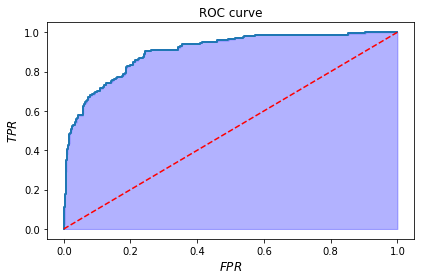

In [82]:
plot_roc_curve(y_test, -y_pred.T[:, 0])

#### Area under ROC curve

In [83]:
# area under the roc curve
def roc_auc_score(y_true, y_score):
    
    assert len(y_true) == len(y_score)
    
    if len(y_score) < 2:
        raise ValueError('at least 2 points are needed to calculate area, but y_score.shape: %s' % y_score.shape)
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    # calculate area under roc_curve
    area = np.trapz(tpr, fpr)
    return area

In [84]:
roc_auc_score(y_test, -y_pred.T[:, 0])

0.9027421222188663

#### 13. Performance on test data

In [85]:
y_test_pred = model.predict(X_test)

print("precision: ", precision_score(y_test, y_test_pred))
print("recall: ", precision_score(y_test, y_test_pred))
print("F1-score: ", f1_score(y_test, y_test_pred))
print("confusion matrix: \n", confusion_matrix(y_test, y_test_pred))
print("accuracy: ", accuracy_score(y_test, y_test_pred))

precision:  0.896551724137931
recall:  0.896551724137931
F1-score:  0.912280701754386
confusion matrix: 
 [[928.  18.]
 [ 12. 156.]]
accuracy:  0.9730700179533214


This simple model has given very a good performance for the Spam email classification problem. There are many places to improve the performance of this model - from the more raw data cleaning to number of features selection when vectorizing the emails. 

***Done!***